# Import the necessary libraries

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split
import spacy as sp
import re
import pickle as pkl
from sklearn import metrics
from sklearn.svm import libsvm,SVC
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Load the spacy model

In [7]:
nlp = sp.load('en_core_web_lg')

# Load the data file and do some preliminary exploration

- Use Panda to read the data csv file
- Check the top 5 rows in the data frame
- Review the unique values of the Category, i.e. the labels
- Get the number of samples per class
- Sample some Snippets

In [21]:
df = pd.read_csv('sampled_data.csv',index_col=0)

In [22]:
df.head()

,Category,Keyword,Snippet,Title
0,Oil and Gas,mining,You are here: Home > Appraisal > Mineral Right...,Oil and Gas Mineral Rights
1,Oil and Gas,extraction,There are many storage wells capable of holdin...,How do you extract oil - Answers.com
2,Oil and Gas,field,Aberdeen Exhibition & Conference Centre: GE Oi...,GE Oil and Gas Arena - Aberdeen Exhibition & C...
3,Oil and Gas,Producers,The UK offshore oil and gas industry benefits ...,About the Industry | Oil & Gas UK
4,Oil and Gas,rig,Search CareerBuilder for Oil Truck Driver Jobs...,Oil Truck Driver Jobs - Apply Now | CareerBuilder


In [8]:
df.Category.unique()

array(['Oil and Gas', 'Materials', 'Technology', 'Utilities',
       'Telecommunications', 'Media', 'Consumer Automobiles',
       'Consumer Services', 'Consumer Retail', 'consumer staples',
       'financial', 'transportation', 'Aerospace and defense',
       'health care', 'construction and engineering',
       'commercial and industrial services', 'professional services',
       'government', 'Real Estate'], dtype=object)

In [23]:
df.Category.value_counts()

Technology                            1000
transportation                        1000
financial                             1000
government                            1000
Aerospace and defense                 1000
Real Estate                           1000
Oil and Gas                           1000
Consumer Retail                       1000
commercial and industrial services    1000
Media                                 1000
professional services                 1000
Consumer Services                     1000
Telecommunications                    1000
health care                           1000
Consumer Automobiles                  1000
Utilities                             1000
consumer staples                      1000
construction and engineering          1000
Materials                             1000
Name: Category, dtype: int64

In [24]:
df['Snippet'][10]

'SGS provides fuel oil testing services through our global network of laboratories. Find out more.'

In [25]:
df['Snippet'][2000]

'Antispam warriors are developing new weapons to fight unwanted junk e-mail and legislators are debating strict new laws that could send spammers to jail. A look at 5 ...'

In [26]:
df['Snippet'][5000]

'Numerous studies have suggested that using social media sites such as Facebook and Twitter can affect mental health and well-being. We look at the evidence.'

# Data Pre-Processing

- Remove the NaNs
- Combine the string data in a new column after converting all the string to lower case
- Clean the text
    + remove non_alphabets
    + use spaCy model to keep Nouns, Verbs and ProNouns
    + use spaCy model to remove non-English words

In [27]:
df.Title.fillna('',inplace=True)
df.Snippet.fillna('',inplace=True)

In [28]:
df['Doc']=df.Keyword+' '+ df.Title.str.lower()+' '+ df.Snippet.str.lower()

In [29]:
df['Doc'][100]

'garage oil and gas iq oil & gas iq offers authoritative insight and opinion on all aspects affecting the oil and gas industry.'

In [31]:
def string_preprocessing(data):
    ''' The function processing the data including: keeping only nouns verbs and pronouns, remove extra characters
    Args:
        data: string
    Returns:
        string
    '''
    
    data = re.sub('[^a-z]',' ',data)
    
    doc = nlp(data)
    text = []
    for word in doc:
        if word.pos_ in ['PROPN','NOUN','VERB'] and np.sum(word.vector) !=0:
            text.append(word.text)
  
    return ' '.join(text)

In [32]:
df['Doc'][1004]

'scaffolding sheet material cut to size mdf plywood veneered sheet material ut to size mdf plywood veneered flexi real wood moisture resistant exotic'

In [33]:
string_preprocessing(df['Doc'][1004])

'scaffolding sheet material cut size plywood veneered sheet material ut size plywood veneered wood moisture'

# Build LDA
- write functions to build an LDA model and to view the generated topics,
- the model uses CountVectorizer as an input to the LDA model
- build LDA for the class Technology to demonstrate the output

In [35]:
def build_lda(data,num_topics):
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                stop_words='english')
    tf = tf_vectorizer.fit_transform(data)
    
    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
    lda.fit(tf)
    
    return lda,tf_vectorizer

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [38]:
#data_tech = df[df['Category']=='Technology']['Doc'].apply(lambda x: string_preprocessing(x))
data_tech = df['Doc'].apply(lambda x: string_preprocessing(x))

In [39]:
lda_technology,tf_vectorizer = build_lda(data_tech,num_topics=10) # change num_topics to see its impact
print_top_words(lda_technology,tf_vectorizer.get_feature_names(),n_top_words=10) # change n_top_words to see its impact

Topic #0: car water used protection cars performance treatment air freight systems
Topic #1: health care sale services minister homes service tax ministry goods
Topic #2: consumer services transportation gas business oil market uk department sector
Topic #3: government company investment management food service financial finance network rights
Topic #4: services office waste auto act recycling computer building plans luxury
Topic #5: estate property materials industrial commercial com house definition properties material
Topic #6: state support utility accounting apartment telecommunications advice credit education satellite
Topic #7: construction engineering aerospace services media technology management solutions jobs design
Topic #8: wikipedia school airport pharmacy tech medicine sport retailers departments music
Topic #9: defense staples city index cable tv video etf manager hotel



## Run LDA for every class in the data
- Assume all classes require the same number of topics
- Clean the text before building the LDA models


In [40]:
n_components = 20

ldas = []
tf_vectorizers = []
for cat in df.Category.unique():
    cat_df = df['Doc'].where(df['Category'] == cat).dropna(how='any')
    cat_df = cat_df.apply(lambda x: string_preprocessing(x))
    lda_t,tf_vectorizer_t = build_lda(cat_df,num_topics=n_components)
    ldas.append(lda_t)
    tf_vectorizers.append(tf_vectorizer_t)

# Save the LDA models
Do not run if you do not want to override the supplied file

In [41]:
with open('tutorial_ldas.pkl','wb') as f:
        pkl.dump((ldas,tf_vectorizers),f,pkl.HIGHEST_PROTOCOL)

## Load the LDA models from an already provided file

In [42]:
with open('tutorial_ldas.pkl','rb') as f:
       (ldas,tf_vectorizers)= pkl.load(f)

# Feature Engineering
- Pass the data to every LDA model, extract and combine the topic features
- if wordEmbed == True then add the spaCy langauge model embedding to the extracted LDA features


In [45]:
def feature_extraction(data,ldas,tf_vects, wordEmbed=True):
    features=[]
    labels =[]
    assert(len(ldas)==len(tf_vects))
    for i,d in data.iterrows():
        labels.append(d['Category'])
        line= []
        for j in range(len(ldas)):
            line.extend(ldas[j].transform(tf_vects[j].transform([d['Doc']]))[0])
        if wordEmbed:
            line.extend(list(nlp(d['Doc']).vector))
        features.append(line)
    return features,labels

In [47]:
features,labels=feature_extraction(df.dropna(how='any'),ldas,tf_vectorizers)

# Save the extracted features
Do not run if you do not want to override the supplied file

In [48]:
with open('tutorial_features.pkl','wb') as f:
        pkl.dump((features,labels),f,pkl.HIGHEST_PROTOCOL)

## Load the extracted features from the provided file

In [49]:
with open('tutorial_features.pkl','rb') as f:
       (features,labels)= pkl.load(f)

# Prepare for classification
- Fit a label encoder to convert String labels into numbers

In [50]:
# encode the labels
le = preprocessing.LabelEncoder()
le.fit(labels)
encoded_labels = le.transform(labels)
n_classes = len(le.classes_)

# Shallow Classifier
- Split the data into training and testing sets
- Train a linear SVM on the training data
- Provide results of the accuracy on the test data

In [51]:
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels,test_size=0.25)
clf = SVC(kernel='linear',probability=True)
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [52]:
print(metrics.classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       232
           1       0.87      0.86      0.86       250
           2       0.78      0.85      0.81       248
           3       0.73      0.79      0.76       265
           4       0.80      0.82      0.81       269
           5       0.84      0.87      0.86       236
           6       0.97      0.94      0.95       234
           7       0.93      0.94      0.94       250
           8       0.83      0.85      0.84       262
           9       0.90      0.89      0.89       262
          10       0.86      0.87      0.87       238
          11       0.94      0.91      0.92       261
          12       0.93      0.93      0.93       249
          13       0.93      0.90      0.91       242
          14       0.86      0.82      0.84       252
          15       0.93      0.93      0.93       256
          16       0.90      0.91      0.91       231
          17       0.89    

# Can you test the shallow classifier on LDA features only?

# Demo
- Define a function to process a string to be suitable to run against the model
- Use the built SVM model to predict the class
- Output the top three classes with their probabilities

In [53]:
def string_features(text,ldas,tf_vectorizers):
        ''' extract lda features for a given text.
        Args:
            text: string
            ldas: a list of LDA models
            tf_vectorizers: a list of CounterVectorizers associated with the ldas
        Returns:
            a list of the lda features with length [number of lda models] X [number of topics per model] 
        '''
        line= []
        for j in range(len(ldas)):
            line.extend(ldas[j].transform(tf_vectorizers[j].transform([text]))[0])
        vec = nlp(text).vector
        line.extend(list(vec))
        return line

In [54]:
while True:
    print('Enter a business description please, q to exit:\n')
    st = input()
    if st == 'q':
        break
    clean_st =  string_preprocessing(st)
    feats = string_features(clean_st,ldas,tf_vectorizers)
    probs = clf.predict_proba([feats])[0]
    idx = np.argsort(probs)[::-1]
    top_probs = probs[idx[:3]]
    top_labels = le.inverse_transform(idx[:3])

    for lbl,prob in zip(top_labels,top_probs):
        print(lbl,':',100*prob)
    print ('*****************\n')

Enter a business description please, q to exit:

protection from financial lose, risk managment, risk of uncertainty 
financial : 34.90091462674359
health care : 17.66488421582849
Utilities : 8.665263563312925
*****************

Enter a business description please, q to exit:

q


# Deep Learning
- Define a Multi-Layer Perceptron to classify the data
- Use Two layer and a softmax layer 
- Use Dropout
- Use Relu activation functions

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

model = Sequential()
# First Layer
model.add(Dense(1150, input_dim=len(X_train[0])))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#Second Layer
model.add(Dense(500))
model.add(Activation('relu'))
#Third Layer
model.add(Dense(n_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Using TensorFlow backend.
/Users/Noura/anaconda/envs/workshop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Noura/anaconda/envs/workshop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Noura/anaconda/envs/workshop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Noura/anac

/Users/Noura/anaconda/envs/workshop/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Noura/anaconda/envs/workshop/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Noura/anaconda/envs/workshop/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Noura/anaconda/



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1150)              783150    
_________________________________________________________________
activation_1 (Activation)    (None, 1150)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1150)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               575500    
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 19)                9519      
_______________________

## Convert the labels from a  noiminal value to one-hot encoded
this is a requirment to be able to run the keras model

In [56]:
from keras.utils import to_categorical
train_label = to_categorical(y_train, num_classes=n_classes)
test_label =  to_categorical(y_test, num_classes=n_classes)

## Train the model
- Define a model checkpoint to save the best model through the training iterations
- Define batch size and Epochs

In [57]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='tutorial_weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True,monitor='val_acc')
hist=model.fit(np.asarray(X_train), train_label, epochs=20, batch_size=100,
               validation_data=(np.asarray(X_test),test_label),callbacks=[checkpointer])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 14250 samples, validate on 4750 samples
Epoch 1/20
14250/14250 [==============================] - 12s 814us/step - loss: 0.9406 - acc: 0.7448 - val_loss: 0.4981 - val_acc: 0.8598

Epoch 00001: val_acc improved from -inf to 0.85979, saving model to tutorial_weights.01-0.50.hdf5
Epoch 2/20
14250/14250 [==============================] - 8s 548us/step - loss: 0.4398 - acc: 0.8752 - val_loss: 0.4428 - val_acc: 0.8785

Epoch 00002: val_acc improved from 0.85979 to 0.87853, saving model to tutorial_weights.02-0.44.hdf5
Epoch 3/20
14250/14250 [==============================] - 8s 564us/step - loss: 0.3432 - acc: 0.8987 - val_loss: 0.4407 - val_acc: 0.8766

Epoch 00003: val_acc did not improve from 0.87853
Epoch 4/20
14250/14250 [==============================] - 8s 565us/step - loss: 0.2933 - acc: 0.9127 - val_loss: 0.4205 - val_acc: 0.8798

Epoch 00004: val_acc improved from 0.87853 to 0.879

## Plot the output to understand the change of training and validation accuracy over training epochs

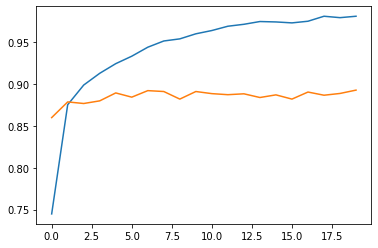

In [58]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

In [59]:
preds = np.argmax(model.predict(np.asarray(X_test)),axis=1)
print(metrics.classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       232
           1       0.87      0.87      0.87       250
           2       0.83      0.85      0.84       248
           3       0.86      0.80      0.83       265
           4       0.81      0.83      0.82       269
           5       0.87      0.92      0.89       236
           6       0.98      0.93      0.95       234
           7       0.95      0.92      0.94       250
           8       0.82      0.89      0.86       262
           9       0.90      0.92      0.91       262
          10       0.92      0.87      0.89       238
          11       0.96      0.93      0.94       261
          12       0.93      0.93      0.93       249
          13       0.87      0.94      0.90       242
          14       0.86      0.84      0.85       252
          15       0.93      0.93      0.93       256
          16       0.93      0.93      0.93       231
          17       0.92    

## Can you test different variations of the model?

## Prepare Data to use in LSTM
- For LSTM the data has to be prepared differently to format it as sequences
- Each element in the sequence is a word embedding from the spaCy language model
- Define max sequence length
- Add zero paddings for shorter seuquences

In [60]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding,LSTM,Bidirectional
from keras.models import Model,Sequential
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint

In [61]:
MAX_NUM_WORDS = nlp.vocab.length # the number of words in the dictionary
MAX_SEQUENCE_LENGTH = 10
EMBEDDING_DIM = 300 # comes from spaCy, if you select a different model this has to change accordingly

In [62]:
#prepare text samples and their labels
texts = df['Doc'].apply(lambda x: string_preprocessing(x))

## Build a Keras tokenizer and convert text into sequences

In [63]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [64]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21903 unique tokens.


## Add padding if required

In [65]:
data_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [66]:
data_seq.shape

(19000, 10)

## Create the embedding layer which is not trainable, this will be the input to the LSTM model

In [67]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = nlp(word).vector
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

Training model.


In [68]:
#LSTM
batch_size = 100
print('Build model...')
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(200, dropout=0.3, recurrent_dropout=0.3,return_sequences=False)) 
# if you want to add another layer set return_sequences to True
#lstm_model.add(Bidirectional(LSTM(50, dropout=0.5, recurrent_dropout=0.5)))
lstm_model.add(Dense(30, activation='tanh'))
lstm_model.add(Dense(19, activation='softmax'))

# try using different optimizers and different optimizer configs
lstm_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
lstm_model.summary()

Build model...
Train...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 300)           6571200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                6030      
_________________________________________________________________
dense_5 (Dense)              (None, 19)                589       
Total params: 6,978,619
Trainable params: 407,419
Non-trainable params: 6,571,200
_________________________________________________________________


In [69]:
# Reformat the labels
seq_labels = to_categorical(encoded_labels,num_classes=n_classes)

In [70]:
checkpoint = ModelCheckpoint(filepath='weights-improvement-lstm-{epoch:02d}-{val_acc:.2f}.hdf5',
                                            monitor='val_loss', verbose=0, save_best_only=True)
hist = lstm_model.fit(data_seq, seq_labels,
          batch_size=batch_size,
          epochs=20,validation_split=0.2,shuffle=True,callbacks=[checkpoint])


score, acc = model.evaluate(data_seq, seq_labels,
                            batch_size=batch_size)
print('Train score:', score)
print('Train accuracy:', acc)

Train on 15200 samples, validate on 3800 samples
Epoch 1/20
15200/15200 [==============================] - 23s 2ms/step - loss: 1.4893 - acc: 0.5959 - val_loss: 4.6712 - val_acc: 0.0371
Epoch 2/20
15200/15200 [==============================] - 18s 1ms/step - loss: 0.9874 - acc: 0.7255 - val_loss: 5.3133 - val_acc: 0.0571
Epoch 3/20
15200/15200 [==============================] - 18s 1ms/step - loss: 0.8803 - acc: 0.7511 - val_loss: 5.3847 - val_acc: 0.0782
Epoch 4/20
15200/15200 [==============================] - 17s 1ms/step - loss: 0.8001 - acc: 0.7719 - val_loss: 5.7765 - val_acc: 0.1053
Epoch 5/20
15200/15200 [==============================] - 17s 1ms/step - loss: 0.7439 - acc: 0.7845 - val_loss: 5.8496 - val_acc: 0.1037
Epoch 6/20
15200/15200 [==============================] - 17s 1ms/step - loss: 0.7022 - acc: 0.7952 - val_loss: 6.1645 - val_acc: 0.0968
Epoch 7/20
15200/15200 [==============================] - 17s 1ms/step - loss: 0.6418 - acc: 0.8130 - val_loss: 6.1563 - val_acc:

ValueError: Error when checking input: expected dense_1_input to have shape (680,) but got array with shape (10,)

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.show()

In [ ]:
pred = lstm_model.predict_classes(data_seq)
print(classification_report(np.argmax(seq_labels,axis=1),pred))

# Is that a better model than an MLP?
- if not what can you change?
- Is the test correct?
